In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 735
predict_for = 14

In [ ]:
def smoothen_freq(df):
  x = df
  nan_indices = np.isnan(x)

  # # Remove the NaN values from the array
  x = x[np.logical_not(nan_indices)]

  # Generate a noisy signal
  signal = x

  # Apply Fourier transform to the signal
  f_signal = np.fft.fft(signal)

  # Calculate the power spectrum
  power = np.abs(f_signal)**2

  # Set a threshold to remove the noise
  threshold = 0.002 * max(power)
  f_signal[power < threshold] = 0

  # Apply inverse Fourier transform to the filtered signal
  filtered_signal = np.fft.ifft(f_signal)

  return filtered_signal


In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
def scale(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

In [ ]:
class Model:
  def __init__(self, df):
    self.scaler = MinMaxScaler()
    self.df = smoothen_freq(df)
    self.df = scale(df, self.scaler)
    self.dfw, self.dfy = prepare_data(self.df)

    self.model_strong = Sequential()
    self.model_strong.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model_strong.add(LSTM(units = 32, return_sequences=True))
    self.model_strong.add(LSTM(units = 32))
    self.model_strong.add(Dense(units = 1))  #our predictions
    self.model_strong.compile(optimizer = 'adam', loss = 'mean_squared_error')




    self.model_weak = Sequential()
    self.model_weak.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(LSTM(units = 32, return_sequences=True))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(LSTM(units = 32))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(Dense(units = 1))  #our predictions
    self.model_weak.compile(optimizer = 'adam', loss = 'mean_squared_error')

  def fit(self):
    # when giving 25% importance to strong model and 75% importance to weak model
    y_train_strong = self.dfy / 4
    y_train_weak = self.dfy * (3 / 4)
    # training the strong model for more epochs
    self.model_strong.fit(self.dfw, y_train_strong, epochs = 10)
    # training the weak model for less epochs
    self.model_weak.fit(self.dfw, y_train_weak, epochs = 4)
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p_strong = [df_full]
    X_p_weak = [df_full]
    y_p_strong = []
    y_p_weak = []

    for i in range(predict_for):
        yi_strong = self.model_strong.predict(np.array(X_p_strong))
        y_p_strong.append(yi_strong[0][0])
        yi_weak = self.model_weak.predict(np.array(X_p_weak))
        y_p_weak.append(yi_weak[0][0])
        X_p_strong = [np.append(X_p_strong[0][1:], yi_strong)]
        X_p_weak = [np.append(X_p_weak[0][1:], yi_weak)]
    y_p = [0 for y_p_i in range(len(y_p_strong))]
    for j in range(len(y_p)):
        y_p[j] = y_p_strong[j] + y_p_weak[j]
    return descaled(y_p, self.scaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
print(df.columns)
print(df.state_residence.unique())
df.head()
df=df.groupby(['Date']).agg({'<15_pos': 'sum', '15-24_pos': 'sum', '25-34_pos':'sum', '35-44_pos':'sum', '45-59_pos':'sum', '60-80_pos':'sum', '>80_pos':'sum', 'new_case': 'sum'}).reset_index()
df.head()

date = df.iloc[train_for + 1]['Date']

Index(['Unnamed: 0', 'state_residence', 'district_residence', 'Date', '<15',
       '15-24', '25-34', '35-44', '45-59', '60-80', '>80', '<15_pos',
       '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos',
       '>80_pos', 'M_pos', '2', 'F_pos', 'T', 'F', 'M', 'NIA', 'T_pos',
       'NIA_pos', 'O', 'O_pos', 'N', 'G', ',', 'D', 'new_case',
       'negative_case', 'Failed_test', 'Total_test',
       'negative_egene_screening', 'positive_egene_screening',
       'Failed_test_egene_screening', '<20_ct_value_screening',
       '20-30_ct_value_screening', '31-35_ct_value_screening',
       '>35_ct_value_screening', '<20_posct_value_screening',
       '20-30_posct_value_screening', '31-35_posct_value_screening',
       '>35_posct_value_screening', 'negative_rdrp_confirmatory',
       'positive_rdrp_confirmatory', 'Failed_test_rdrp_confirmatory',
       '<20_ct_value_rdrp', '20-30_ct_value_rdrp', '31-35_ct_value_rdrp',
       '>35_ct_value_rdrp', '<20_posct_value_rdrp', '20-30_po

In [ ]:
age_groups = ['<15_pos', '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos', '>80_pos']

df_age_wise = {}

for age_group in age_groups:
  df_age_wise[age_group] = df[age_group].values

df_total = df['new_case'].values


In [ ]:
models = {}
for age_group in age_groups:
  models[age_group] = Model(df_age_wise[age_group][:train_for])

In [ ]:
counter = 0
for age_group in age_groups:
  print('*************************************************************')
  print(counter, "/", len(age_groups))
  print('*************************************************************')
  counter += 1
  models[age_group].fit()

*************************************************************
0 / 7
*************************************************************
Epoch 1/10
22/22 [==============================] - 11s 57ms/step - loss: 4.8837e-04
Epoch 2/10
22/22 [==============================] - 1s 58ms/step - loss: 2.9932e-04
Epoch 3/10
22/22 [==============================] - 1s 57ms/step - loss: 2.6929e-04
Epoch 4/10
22/22 [==============================] - 1s 56ms/step - loss: 2.3601e-04
Epoch 5/10
22/22 [==============================] - 1s 55ms/step - loss: 2.2150e-04
Epoch 6/10
22/22 [==============================] - 1s 57ms/step - loss: 2.3152e-04
Epoch 7/10
22/22 [==============================] - 1s 57ms/step - loss: 2.1617e-04
Epoch 8/10
22/22 [==============================] - 1s 68ms/step - loss: 2.0655e-04
Epoch 9/10
22/22 [==============================] - 1s 66ms/step - loss: 2.0170e-04
Epoch 10/10
22/22 [==============================] - 1s 55ms/step - loss: 1.8777e-04
Epoch 1/4
22/22 [===========

In [ ]:
def mape_(p, a):
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100

In [ ]:
predictions = models[age_groups[0]].predict(predict_for)

for i in range(1, len(age_groups)):
  predictions = predictions + models[age_groups[i]].predict(predict_for)

1/1 [==============================] - 0s 27ms/step


In [ ]:
actual = df_total[train_for:train_for+predict_for]

MAPE = mape_(predictions, actual)
print("MAPE:", MAPE)

MAPE: 73.3514699864017


In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

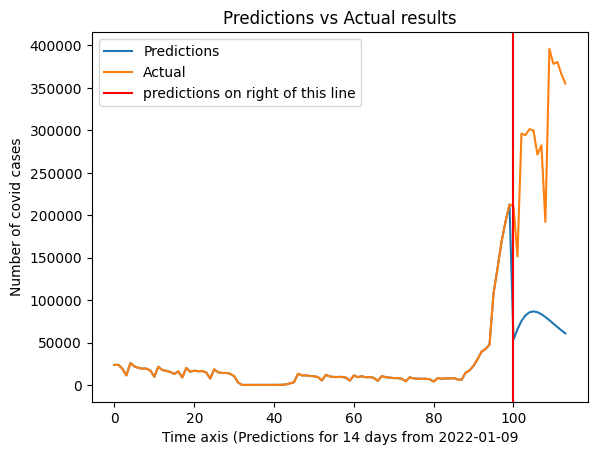

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results")
plt.plot(append(df_total[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df_total[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
counter = 0
for age_group in age_groups:
  print('*************************************************************')
  print(counter, "/", len(age_groups))
  print('*************************************************************')
  counter += 1
  models[age_group].model_strong.save("/content/drive/MyDrive/saved_models/model_strong_" + age_group + "_" + date + ".h5")
  models[age_group].model_weak.save("/content/drive/MyDrive/saved_models/model_weak_" + age_group + "_" + date + ".h5")

*************************************************************
0 / 7
*************************************************************
*************************************************************
1 / 7
*************************************************************
*************************************************************
2 / 7
*************************************************************
*************************************************************
3 / 7
*************************************************************
*************************************************************
4 / 7
*************************************************************
*************************************************************
5 / 7
*************************************************************
*************************************************************
6 / 7
*************************************************************


In [ ]:
print(predictions)

[53406.594 65619.88  75363.77  82008.57  85636.82  86687.31  85742.64
 83377.96  80095.82  76298.52  72286.984 68271.62  64382.285 60701.57 ]


In [ ]:
print(actual)

[210776. 151381. 296176. 294335. 301381. 299917. 271532. 282287. 192190.
 395946. 378298. 380601. 366328. 355255.]
